In [309]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, plot_confusion_matrix


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [310]:
TRAIN_DATA_PATH = "../input/titanic/train.csv"
TEST_DATA_PATH = "../input/titanic/test.csv"

In [311]:
data = pd.read_csv(TRAIN_DATA_PATH)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Exploring the Data

In [312]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [313]:
# Checking for duplicacy
len(data["PassengerId"].unique()) == data.shape[0]

True

We can see that is no duplicacy present in the data. Let us drop the PassengerId, Name, Ticket from the data.

In [314]:
data.drop(columns=["PassengerId", "Name", "Ticket"],inplace=True)

In [315]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64


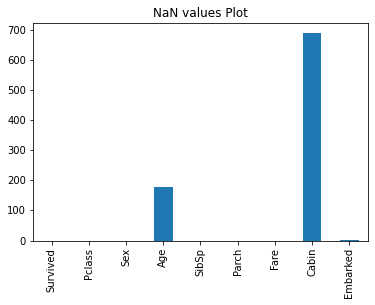

In [316]:
print(data.isnull().sum())
data.isnull().sum().plot(kind = "bar")
plt.title("NaN values Plot")
plt.show()

## Univariate Analysis

Survived: 38.38383838383838%
Not Survived: 61.61616161616161%



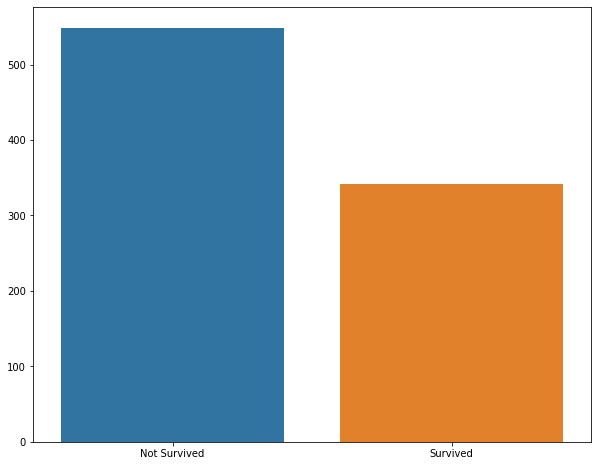

In [317]:
# Checking the data if it is balanced or not

counts = data["Survived"].value_counts()
diag_cols = ["Not Survived", "Survived"]
diag_counts = [counts[0], counts[1]]

nd = (diag_counts[0] / sum(diag_counts))*100
d = (diag_counts[1] / sum(diag_counts)) * 100

print(f"Survived: {d}%")
print(f"Not Survived: {nd}%")

print()

plt.figure(figsize = (10, 8))
sns.barplot(x = diag_cols, y = diag_counts)
plt.show()

In [318]:
data["Pclass"].unique()

array([3, 1, 2])

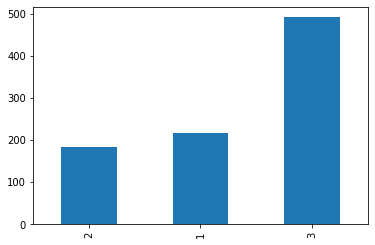

In [319]:
data["Pclass"].value_counts().sort_values().plot(kind = "bar")
plt.show()

In [320]:
data.groupby("Pclass")["Survived"].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

Here we an see that the survivors mostly belonged to class 1 which is obvious. The 1st class people were given more priority than the 2nd and 3rd class people.

In [321]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


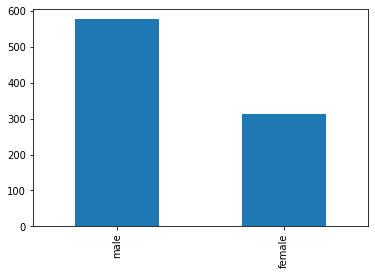

In [322]:
data["Sex"].value_counts().plot(kind = "bar")
plt.show()

In [323]:
data.groupby("Sex")["Survived"].mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

Here we an see that the survivors were mostly feamle which is obvious. Let us change the encoding for the Sex feature. Let us replace it with the values generated using Target Guided Encoding.

In [324]:
sex_map = {"female":1, "male":0}
data["Sex"] = data["Sex"].map(sex_map).values.copy()

In [325]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,0,22.0,1,0,7.2500,NaN,S
1,1,1,1,38.0,1,0,71.2833,C85,C
2,1,3,1,26.0,0,0,7.9250,NaN,S
3,1,1,1,35.0,1,0,53.1000,C123,S
4,0,3,0,35.0,0,0,8.0500,NaN,S


In [326]:
print(f"Number of missing values in Age: {data['Age'].isnull().sum()}")

Number of missing values in Age: 177


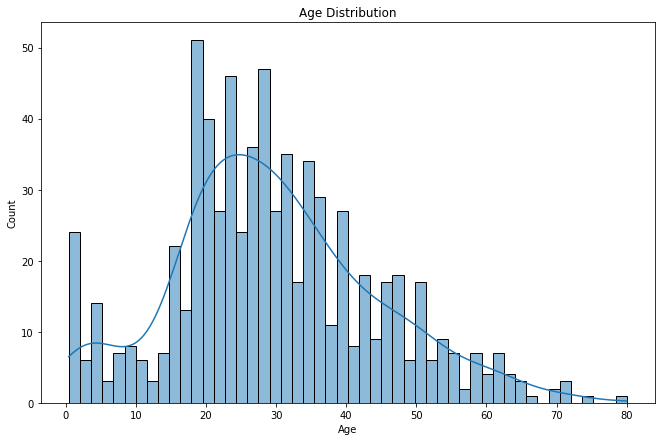

In [327]:
plt.figure(figsize = (11, 7))
sns.histplot(data["Age"], kde=True, bins = 50)
plt.title("Age Distribution")
plt.show()

Using mean imputation let us fill the missing values in the age feature.

In [328]:
data["Age"].fillna(data["Age"].mean(), inplace=True)

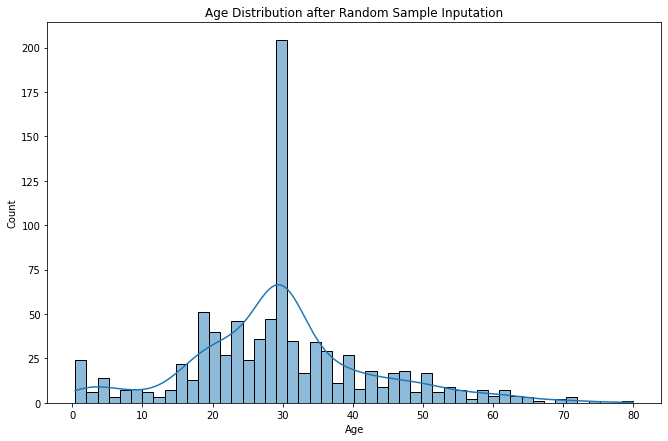

In [329]:
plt.figure(figsize = (11, 7))
sns.histplot(data["Age"], kde=True, bins = 50)
plt.title("Age Distribution after Random Sample Inputation")
plt.show()

In [330]:
print(f"Number of missing values in Age: {data['Age'].isnull().sum()}")

Number of missing values in Age: 0


In [331]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,0,22.0,1,0,7.2500,NaN,S
1,1,1,1,38.0,1,0,71.2833,C85,C
2,1,3,1,26.0,0,0,7.9250,NaN,S
3,1,1,1,35.0,1,0,53.1000,C123,S
4,0,3,0,35.0,0,0,8.0500,NaN,S


In [332]:
data["SibSp"].unique()

array([1, 0, 3, 4, 2, 5, 8])

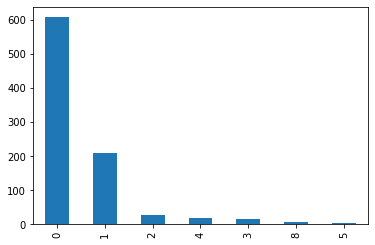

In [333]:
data["SibSp"].value_counts().plot(kind = "bar")
plt.show()

In [334]:
data.groupby("SibSp")["Survived"].mean()

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64

In [335]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,0,22.0,1,0,7.2500,NaN,S
1,1,1,1,38.0,1,0,71.2833,C85,C
2,1,3,1,26.0,0,0,7.9250,NaN,S
3,1,1,1,35.0,1,0,53.1000,C123,S
4,0,3,0,35.0,0,0,8.0500,NaN,S


In [336]:
data["Parch"].unique()

array([0, 1, 2, 5, 3, 4, 6])

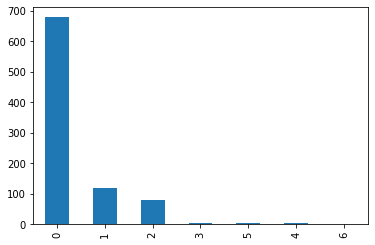

In [337]:
data["Parch"].value_counts().plot(kind = "bar")
plt.show()

In [338]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,0,22.0,1,0,7.2500,NaN,S
1,1,1,1,38.0,1,0,71.2833,C85,C
2,1,3,1,26.0,0,0,7.9250,NaN,S
3,1,1,1,35.0,1,0,53.1000,C123,S
4,0,3,0,35.0,0,0,8.0500,NaN,S


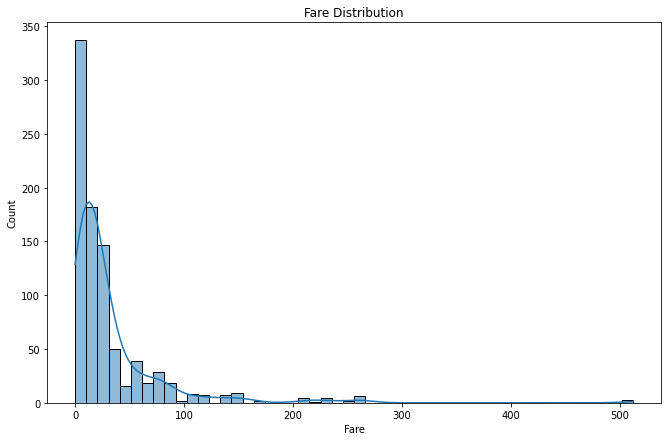

In [339]:
plt.figure(figsize = (11, 7))
sns.histplot(data["Fare"], kde=True, bins = 50)
plt.title("Fare Distribution")
plt.show()

In [340]:
data["Fare"].isnull().sum()

0

In [341]:
print(f"Number of missing values in Cabin: {data['Cabin'].isnull().sum()}")

Number of missing values in Cabin: 687


In [342]:
data.drop(columns = ["Cabin"], inplace = True)

In [343]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,S
1,1,1,1,38.0,1,0,71.2833,C
2,1,3,1,26.0,0,0,7.9250,S
3,1,1,1,35.0,1,0,53.1000,S
4,0,3,0,35.0,0,0,8.0500,S


In [344]:
data["Embarked"].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [345]:
data["Embarked"].fillna(data["Embarked"].mode()[0], inplace = True)

In [346]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,S
1,1,1,1,38.0,1,0,71.2833,C
2,1,3,1,26.0,0,0,7.9250,S
3,1,1,1,35.0,1,0,53.1000,S
4,0,3,0,35.0,0,0,8.0500,S


In [347]:
data["Embarked"].unique()

array(['S', 'C', 'Q'], dtype=object)

In [348]:
data.groupby("Embarked")["Survived"].mean()

Embarked
C    0.553571
Q    0.389610
S    0.339009
Name: Survived, dtype: float64

In [349]:
embark_map = {
    "S":0,
    "Q":1,
    "C":2
}

data["Embarked"] = data["Embarked"].map(embark_map).values

In [350]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,0
1,1,1,1,38.0,1,0,71.2833,2
2,1,3,1,26.0,0,0,7.9250,0
3,1,1,1,35.0,1,0,53.1000,0
4,0,3,0,35.0,0,0,8.0500,0


## Bivariate Analysis

<Figure size 720x720 with 0 Axes>

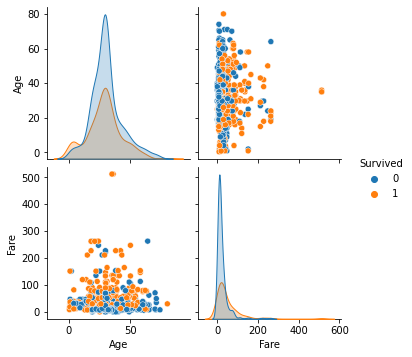

In [351]:
continuous_data_cols = ["Age", "Fare"]
plt.figure(figsize = (10,10))
sns.pairplot(data[continuous_data_cols+["Survived"]], hue="Survived")
plt.show()

## Cleaning the Test Data

In [354]:
test_data = pd.read_csv(TEST_DATA_PATH)

test_data.drop(columns = ["Name", "Cabin", "Ticket"], inplace = True)

print("Missing Values")
print(test_data.isnull().sum())

test_data["Age"].fillna(test_data["Age"].mean(), inplace = True)

test_data['Fare'].fillna(test_data["Fare"].mean() ,inplace = True)

test_data["Sex"] = test_data["Sex"].map(sex_map)
test_data["Embarked"] = test_data["Embarked"].map(embark_map)


print()
print("Missing Values")
print(test_data.isnull().sum())

test_data.head()

Missing Values
PassengerId     0
Pclass          0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            1
Embarked        0
dtype: int64

Missing Values
PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,0,34.5,0,0,7.8292,1
1,893,3,1,47.0,1,0,7.0000,0
2,894,2,0,62.0,0,0,9.6875,1
3,895,3,0,27.0,0,0,8.6625,0
4,896,3,1,22.0,1,1,12.2875,0


## Checking for best Baseline Model

In [355]:
all_columns = list(data.columns)
X = data[all_columns[1:]]
y = data["Survived"]
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [356]:
all_models = {
    "xgb_model":XGBClassifier(eval_metric = "logloss",random_state=18),
    "rf_model":RandomForestClassifier(random_state = 18),
    "logistic_model":LogisticRegression(),
    "svm_model":SVC(),
    "ada_model":AdaBoostClassifier(RandomForestClassifier(random_state = 18))
}

for model_name in all_models:
    print(f"Model Name: {model_name}")
    cv_score = cross_val_score(all_models[model_name],X, y, cv = 5)
    print(cv_score)
    print(f"Mean Score: {np.mean(cv_score)}")
    print()

Model Name: xgb_model
[0.7877095  0.81460674 0.84269663 0.78651685 0.83146067]
Mean Score: 0.8125980792166217

Model Name: rf_model
[0.79329609 0.81460674 0.84269663 0.7752809  0.8258427 ]
Mean Score: 0.8103446111355218

Model Name: logistic_model
[0.77653631 0.78651685 0.78089888 0.76404494 0.81460674]
Mean Score: 0.7845207457158998

Model Name: svm_model
[0.83240223 0.82022472 0.81460674 0.80337079 0.86516854]
Mean Score: 0.827154604230745

Model Name: ada_model
[0.77653631 0.79213483 0.83707865 0.76404494 0.84831461]
Mean Score: 0.8036218693114054



In [357]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 24)
print(f"Train Data: {X_train.shape}. {y_train.shape}")
print(f"Test Data: {X_test.shape}. {y_test.shape}")

Train Data: (712, 7). (712,)
Test Data: (179, 7). (179,)


## SVM Model

On Test Data
Accuracy: 0.8379888268156425
F1 Score: 0.7603305785123968
Precision: 0.7796610169491526
Recall: 0.7419354838709677


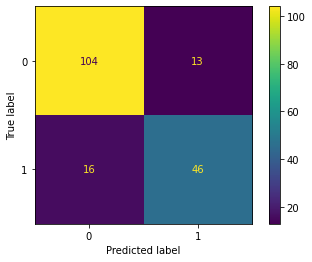


On Train Data
Accuracy: 0.8328651685393258
F1 Score: 0.7733333333333333
Precision: 0.8285714285714286
Recall: 0.725


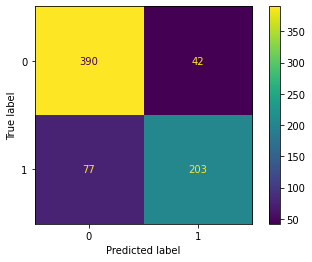

In [358]:
svm_model = SVC()
svm_model.fit(X_train, y_train)

print("On Test Data")
predictions = svm_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, predictions)}")
print(f"F1 Score: {f1_score(y_test, predictions)}")
print(f"Precision: {precision_score(y_test, predictions)}")
print(f"Recall: {recall_score(y_test, predictions)}")
plot_confusion_matrix(svm_model, X_test, y_test)
plt.show()

print()

print("On Train Data")
predictions = svm_model.predict(X_train)
print(f"Accuracy: {accuracy_score(y_train, predictions)}")
print(f"F1 Score: {f1_score(y_train, predictions)}")
print(f"Precision: {precision_score(y_train, predictions)}")
print(f"Recall: {recall_score(y_train, predictions)}")
plot_confusion_matrix(svm_model, X_train, y_train)
plt.show()

## Hyperparameter Tuning for SVM Model

In [359]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 0)
grid.fit(X_train, y_train)

print("Best Params:",grid.best_params_)
print("Best Estimator", grid.best_estimator_)

Best Params: {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
Best Estimator SVC(C=1000, gamma=0.01)


On Test Data
Accuracy: 0.8379888268156425
F1 Score: 0.7642276422764228
Precision: 0.7704918032786885
Recall: 0.7580645161290323


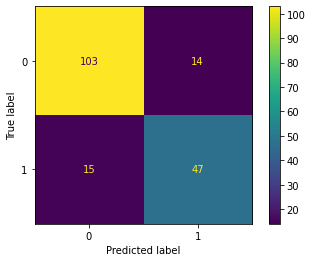


On Train Data
Accuracy: 0.8370786516853933
F1 Score: 0.7769230769230769
Precision: 0.8416666666666667
Recall: 0.7214285714285714


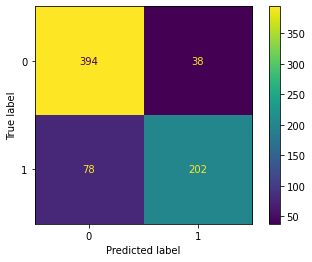

In [360]:
svm_model = SVC(C=1000, gamma=0.01)
svm_model.fit(X_train, y_train)

print("On Test Data")
predictions = svm_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, predictions)}")
print(f"F1 Score: {f1_score(y_test, predictions)}")
print(f"Precision: {precision_score(y_test, predictions)}")
print(f"Recall: {recall_score(y_test, predictions)}")
plot_confusion_matrix(svm_model, X_test, y_test)
plt.show()

print()

print("On Train Data")
predictions = svm_model.predict(X_train)
print(f"Accuracy: {accuracy_score(y_train, predictions)}")
print(f"F1 Score: {f1_score(y_train, predictions)}")
print(f"Precision: {precision_score(y_train, predictions)}")
print(f"Recall: {recall_score(y_train, predictions)}")
plot_confusion_matrix(svm_model, X_train, y_train)
plt.show()

## RandomForest Model

On Test Data
Accuracy: 0.8268156424581006
F1 Score: 0.743801652892562
Precision: 0.7627118644067796
Recall: 0.7258064516129032


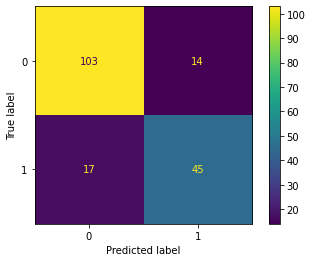


On Train Data
Accuracy: 0.9845505617977528
F1 Score: 0.9802513464991024
Precision: 0.9855595667870036
Recall: 0.975


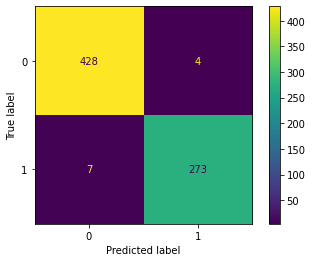

In [361]:
rf_model = RandomForestClassifier(random_state = 18)
rf_model.fit(X_train, y_train)

print("On Test Data")
predictions = rf_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, predictions)}")
print(f"F1 Score: {f1_score(y_test, predictions)}")
print(f"Precision: {precision_score(y_test, predictions)}")
print(f"Recall: {recall_score(y_test, predictions)}")
plot_confusion_matrix(rf_model, X_test, y_test)
plt.show()

print()

print("On Train Data")
predictions = rf_model.predict(X_train)
print(f"Accuracy: {accuracy_score(y_train, predictions)}")
print(f"F1 Score: {f1_score(y_train, predictions)}")
print(f"Precision: {precision_score(y_train, predictions)}")
print(f"Recall: {recall_score(y_train, predictions)}")
plot_confusion_matrix(rf_model, X_train, y_train)
plt.show()

## Hyperparameter Tuning for Random Forest Model

In [362]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier(random_state = 24)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=24, n_jobs = -1)
rf_random.fit(X_train, y_train)

print("Best Params:",rf_random.best_params_)
print("Best Estimator", rf_random.best_estimator_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Params: {'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': False}
Best Estimator RandomForestClassifier(bootstrap=False, max_depth=80, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=600, random_state=24)


On Test Data
Accuracy: 0.8268156424581006
F1 Score: 0.7479674796747967
Precision: 0.7540983606557377
Recall: 0.7419354838709677


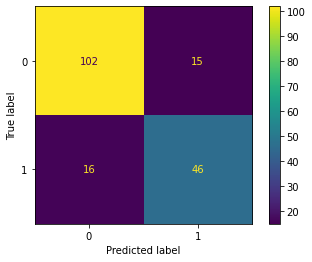


On Train Data
Accuracy: 0.9438202247191011
F1 Score: 0.9264705882352942
Precision: 0.9545454545454546
Recall: 0.9


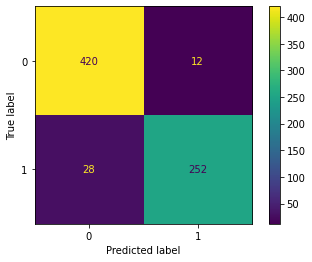

In [363]:
rf_model = RandomForestClassifier(bootstrap=False, max_depth=80, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=600, random_state=24)
rf_model.fit(X_train, y_train)

print("On Test Data")
predictions = rf_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, predictions)}")
print(f"F1 Score: {f1_score(y_test, predictions)}")
print(f"Precision: {precision_score(y_test, predictions)}")
print(f"Recall: {recall_score(y_test, predictions)}")
plot_confusion_matrix(rf_model, X_test, y_test)
plt.show()

print()

print("On Train Data")
predictions = rf_model.predict(X_train)
print(f"Accuracy: {accuracy_score(y_train, predictions)}")
print(f"F1 Score: {f1_score(y_train, predictions)}")
print(f"Precision: {precision_score(y_train, predictions)}")
print(f"Recall: {recall_score(y_train, predictions)}")
plot_confusion_matrix(rf_model, X_train, y_train)
plt.show()

## XGBoost Model

[13:12:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
On Test Data
Accuracy: 0.8212290502793296
F1 Score: 0.7575757575757576
Precision: 0.7142857142857143
Recall: 0.8064516129032258


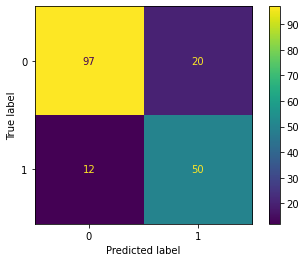


On Train Data
Accuracy: 0.9691011235955056
F1 Score: 0.9598540145985403
Precision: 0.9813432835820896
Recall: 0.9392857142857143


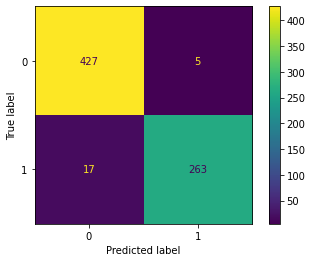

In [364]:
xgb_model = XGBClassifier(random_state = 18)
xgb_model.fit(X_train, y_train)

print("On Test Data")
predictions =xgb_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, predictions)}")
print(f"F1 Score: {f1_score(y_test, predictions)}")
print(f"Precision: {precision_score(y_test, predictions)}")
print(f"Recall: {recall_score(y_test, predictions)}")
plot_confusion_matrix(xgb_model, X_test, y_test)
plt.show()

print()

print("On Train Data")
predictions =xgb_model.predict(X_train)
print(f"Accuracy: {accuracy_score(y_train, predictions)}")
print(f"F1 Score: {f1_score(y_train, predictions)}")
print(f"Precision: {precision_score(y_train, predictions)}")
print(f"Recall: {recall_score(y_train, predictions)}")
plot_confusion_matrix(xgb_model, X_train, y_train)
plt.show()

## Adaboost Model

On Test Data
Accuracy: 0.8435754189944135
F1 Score: 0.7741935483870968
Precision: 0.7741935483870968
Recall: 0.7741935483870968


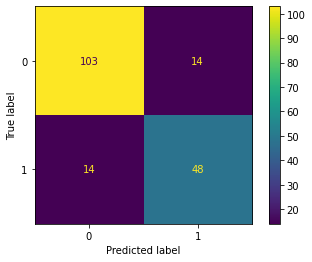


On Train Data
Accuracy: 0.8258426966292135
F1 Score: 0.7712177121771218
Precision: 0.7977099236641222
Recall: 0.7464285714285714


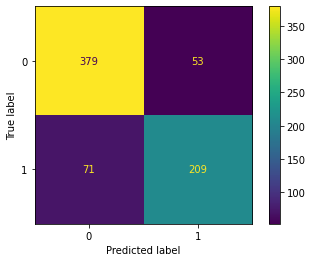

In [365]:
ada_model = AdaBoostClassifier()
ada_model.fit(X_train, y_train)

print("On Test Data")
predictions = ada_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, predictions)}")
print(f"F1 Score: {f1_score(y_test, predictions)}")
print(f"Precision: {precision_score(y_test, predictions)}")
print(f"Recall: {recall_score(y_test, predictions)}")
plot_confusion_matrix(ada_model, X_test, y_test)
plt.show()

print()

print("On Train Data")
predictions = ada_model.predict(X_train)
print(f"Accuracy: {accuracy_score(y_train, predictions)}")
print(f"F1 Score: {f1_score(y_train, predictions)}")
print(f"Precision: {precision_score(y_train, predictions)}")
print(f"Recall: {recall_score(y_train, predictions)}")
plot_confusion_matrix(ada_model, X_train, y_train)
plt.show()

## Voting Classifier (RandomForest + XGBoost + SVM)

On Test Data
Accuracy: 0.8379888268156425
F1 Score: 0.7642276422764228
Precision: 0.7704918032786885
Recall: 0.7580645161290323


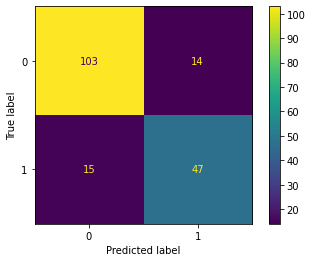


On Train Data
Accuracy: 0.9424157303370787
F1 Score: 0.9242144177449169
Precision: 0.9578544061302682
Recall: 0.8928571428571429


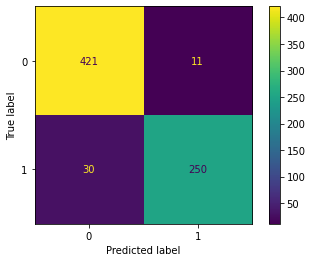

In [368]:
voting_model = VotingClassifier(
    [
        ("rf_model", RandomForestClassifier(bootstrap=False, max_depth=80, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=600, random_state=24)),
        ("xgb_model", XGBClassifier(eval_metric="logloss", random_state = 18)),
        ("svm_model", SVC(C=1000, gamma=0.01))
    ]
)

voting_model.fit(X_train, y_train)

print("On Test Data")
predictions = voting_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, predictions)}")
print(f"F1 Score: {f1_score(y_test, predictions)}")
print(f"Precision: {precision_score(y_test, predictions)}")
print(f"Recall: {recall_score(y_test, predictions)}")
plot_confusion_matrix(voting_model, X_test, y_test)
plt.show()

print()

print("On Train Data")
predictions = voting_model.predict(X_train)
print(f"Accuracy: {accuracy_score(y_train, predictions)}")
print(f"F1 Score: {f1_score(y_train, predictions)}")
print(f"Precision: {precision_score(y_train, predictions)}")
print(f"Recall: {recall_score(y_train, predictions)}")
plot_confusion_matrix(voting_model, X_train, y_train)
plt.show()

## Voting Classifier (RandomForest + XGBoost + AdaBoost)

On Test Data
Accuracy: 0.8379888268156425
F1 Score: 0.768
Precision: 0.7619047619047619
Recall: 0.7741935483870968


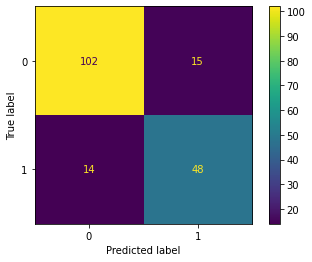


On Train Data
Accuracy: 0.9438202247191011
F1 Score: 0.9261992619926199
Precision: 0.9580152671755725
Recall: 0.8964285714285715


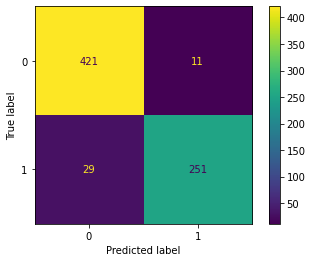

In [370]:
voting_model = VotingClassifier(
    [
        ("rf_model", RandomForestClassifier(bootstrap=False, max_depth=80, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=600, random_state=24)),
        ("xgb_model", XGBClassifier(eval_metric="logloss",random_state = 18)),
        ("ada_model", AdaBoostClassifier())
    ]
)

voting_model.fit(X_train, y_train)

print("On Test Data")
predictions = voting_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, predictions)}")
print(f"F1 Score: {f1_score(y_test, predictions)}")
print(f"Precision: {precision_score(y_test, predictions)}")
print(f"Recall: {recall_score(y_test, predictions)}")
plot_confusion_matrix(voting_model, X_test, y_test)
plt.show()

print()

print("On Train Data")
predictions = voting_model.predict(X_train)
print(f"Accuracy: {accuracy_score(y_train, predictions)}")
print(f"F1 Score: {f1_score(y_train, predictions)}")
print(f"Precision: {precision_score(y_train, predictions)}")
print(f"Recall: {recall_score(y_train, predictions)}")
plot_confusion_matrix(voting_model, X_train, y_train)
plt.show()

In [371]:
test_data.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,0,34.5,0,0,7.8292,1
1,893,3,1,47.0,1,0,7.0000,0
2,894,2,0,62.0,0,0,9.6875,1
3,895,3,0,27.0,0,0,8.6625,0
4,896,3,1,22.0,1,1,12.2875,0


In [380]:
final_voting_model = VotingClassifier(
    [
        ("rf_model", RandomForestClassifier(bootstrap=False, max_depth=80, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=600, random_state=24)),
        ("xgb_model", XGBClassifier(eval_metric="logloss", random_state = 18)),
        ("svm_model", SVC(C=1000, gamma=0.01))
    ]
)

final_voting_model.fit(X, y)

VotingClassifier(estimators=[('rf_model',
                              RandomForestClassifier(bootstrap=False,
                                                     max_depth=80,
                                                     min_samples_leaf=2,
                                                     min_samples_split=5,
                                                     n_estimators=600,
                                                     random_state=24)),
                             ('xgb_model',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            eval_metric='logloss', gamma=None,
                                            gpu_id=None, importance_type...
                                            interaction_

In [381]:
test_X = test_data.iloc[:, 1:]
test_X = scaler.transform(test_X)
test_predictions = final_voting_model.predict(test_X)

In [382]:
submission = pd.DataFrame({
    "PassengerId":test_data["PassengerId"].values,
    "Survived":test_predictions
})
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
